# Classification: I

*N. Pol (2025)*

This lecture and notebook are based on the "Classification" and "Classification2" lectures of of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), which in turn are based on materials from Andy Connolly, and Ivezic et al. Chapter 9, Andy Connolly's [blog](http://connolly.github.io/introAstroML/blog/regression.html), and Aurelien Geron's [book](https://github.com/ageron/handson-ml2). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 9.

---

## Contents
* [Generative vs Discriminative Classification](#one)
* [Comparing the performance of classifiers](#two)
* [Generative classifiers](#three)
* [Simplest classifier: naive Bayes](#four)
* [Gaussian naive Bayes](#five)
* [Linear & Quadratic discriminant analysis](#six)
* [GMM & Bayes classification](#seven)
* [$K$-nearest neighbor classifier](#eight)
    
---

***Exercises required for class participation are in <font color='red'>red</font>. Points will be given this week mostly for producing and understanding the notebook plots. But there are also discussions to be had amongst your classmates.***

---

Several weeks ago we looked at density estimation and clustering, which are **unsupervised** forms of classification. Let's now look at **supervised** classification. This is where we actually know the "truth" for some of our objects and can use that information to help guide the classification of unknown objects.


## Generative vs. Discriminative Classification <a class="anchor" id="one"></a>

We will talk about two different types of classification where each has a slightly different approach.  As an example, if you are trying to determine whether your neighbor is speaking Spanish or Portuguese, you could 1) learn both Spanish and Portuguese so that you'd know exactly what they are saying or 2) learn the keys rules about the differences between the languages.

- If we find ourselves asking which category is most likely to generate the observed result, then we are using using **density estimation** for classification and this is referred to as **generative classification**. Here we have a full model of the density for each class or we have a model which describes how data could be generated from each class. 


- But if we don't care about the full distribution, then we are doing something more like clustering, where we don't need to map the distribution, we just need to define *boundaries*.  Classification that finds the **decision boundary** that separates classes is called **discriminative classification**.  For high-dimensional data, this may be a better choice.

For example, in the figure below, to classify a new object with $x=1$, it would suffice to know that either 
1. model 1 is a better fit than model 2 (***generative classification***), or 
2. that the decision boundary is at $x=1.4$ (***discriminative classification***).

![Ivezic, Figure 9.1](http://www.astroml.org/_images/fig_bayes_DB_1.png)


### Assessing Your Results

Before even introducing different schemes, let's talk about how we define the success of our classification. We'll bring back some concepts from the start of the course. 

Let's first consider **binary classification** where each observation is assigned to either **class=+1** or **class=-1** (or 0 depending on your preference). Let's ignore for now the fact that each observation can be assigned a probability of belonging to class 1 or -1 and we'll only allow those two possibilities (e.g., in the figure above $x=2$ is class +1 and $x=-0.5$ is class -1). 

In that case, there are 2 types of errors (where our goal is to identify class +1 objects):
* a **[False Positive](https://en.wikipedia.org/wiki/False_positives_and_false_negatives#False_positive_error)**, where we have assigned a *true* class label when it is really false. ---> ***Type-1 error***.
* a **[False Negative](https://en.wikipedia.org/wiki/False_positives_and_false_negatives#False_positive_error)**, where we have assigned a *false* class label when it is really true. ---> ***Type-II error***.

All 4 [possibilities](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) are (if you want apples [$g_2$], but not oranges [$g_1$]):
- **True Positive** = ***correctly identified***  (apple identified as apple)
- **True Negative** = ***correctly rejected***  (orange rejected as orange)
- **False Positive** = ***incorrectly identified***  (orange identified as apple)
- **False Negative** = ***incorrectly rejected***  (apple rejected as orange)

Based on these, we usually define either of the following pairs of terms.  Which is used is largely a matter of preference in different fields, but we'll see that there are some key differences.

$$ 
{\rm completeness} = \frac{\rm true\ positives}{\rm true\ positives + false\ negatives} = {\rm true\ positive\ rate\ /\ sensitivity\ /\ recall}
$$

$$  
{\rm contamination} = \frac{\rm false\ positives}{\rm true\ positives + false\ positives} = {\rm false\ discovery\ rate}
$$

or

$$ 
{\rm true\ positive\ rate} = \frac{\rm true\ positives} {\rm true\ positives + false\ negatives}
$$

$$  
{\rm false\ positive\ rate} = \frac{\rm false\ positives} {\rm true\ negatives + false\ positives} = {\rm Type1\ error}
$$

Similarly 
 
$$
{\rm efficiency} = 1 - {\rm contamination} = {\rm precision}. 
$$

Depending on your goals, you may want to maximize the completeness or the efficiency, or a combination of both.

To better understand the differences between these measures, let's take the needle in a haystack problem.  You have 100,000 stars and 1000 quasars.  If you correctly identify 900 quasars as such and mistake 1000 stars for quasars, then we have:
- TP = 900
- FN  = 100
- TN = 99,000
- FP = 1000

Which gives

$$
{\rm true\ positive\ rate} = \frac{900}{900 + 100} = 0.9 = {\rm completeness}
$$

$$
{\rm false\ positive\ rate} = \frac{1000}{99000 + 1000} = 0.01
$$

Not bad right?  Well, sort of.  The FPR isn't bad, but there are *lots* of stars, so the contamination rate isn't so great. <font color='red'>Compute and write this below.</font>

<!--- 
$$
{\rm contamination} = \frac{1000}{900 + 1000} = 0.53
$$
-->

In [1]:
tp = 900
fn = 100
tn = 99000
fp = 1000

contamination = fp / (tp + fp)

print("The contamination is: ", contamination)

The contamination is:  0.5263157894736842


## Comparing the performance of classifiers <a class="anchor" id="two"></a>

"Best" performance is subjective; we trade contamination versus completeness depending on the science. Before we even talk about different classification schemes, let's first talk about how we can quantify which of the methods is "best".  (N.B.  We have skipped ahead to Ivezic $\S$ 9.9).  

We do this with a [**Receiver Operating Characteristic (ROC)**](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve. **A ROC curve simply plots the true-positive vs. the false-positive rate.** 

One concern about ROC curves is that they are sensitive to the relative sample sizes. As we already demonstrated above, **if there are many more background events than source events, small false positive results can dominate a signal.** For these cases ***we can plot completeness versus efficiency (1 - contamination).***

Here is a comparison of the two types of plots:

![Ivezic, Figure 9.17](http://www.astroml.org/_images/fig_ROC_curve_1.png)

Here we see that to get higher completeness, you could actually suffer significantly in terms of efficiency, but your FPR might not go up that much if there are lots of true negatives.

Note that you ***choose*** the completeness and efficiency that you want by choosing a **threshold (decision boundary)**. The curves show you what your possible choices are (depending on where you set the threshold). Generally, you want to chose a decision boundary that maximizes the area under the ROC curve.

Below is the code that makes these plots.  We'll talk about the data that goes into it in a bit.  For now, we'll concentrate on how to generate the ROC and completeness-contamination plots. We'll be comparing 7 different classifiers (with a generic `clf` object), making training and test sets with `split_samples`, then using these tools to generate our plots:

- [sklearn.metrics.roc_curve(y_test, y_prob)](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [sklearn.metrics.precision_recall_curve(y_test, y_prob)](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html)
- astroML.utils.completeness_contamination(y_pred, y_test)

Note that the [`sklearn.metrics` algorithms](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) take `y_test`, which are classes, and `y_prob`, which are not class predictions, but rather probabilities, whereas the AstroML algorithm wants `y_pred` (which we get by converting `y_prob` into discrete predictions as a function of the probability).

**NOTE!!** `sklearn-0.23.2` works with the following code. Newer versions may break. If so, revert to 0.23.2.

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

c:\Users\tonyt\AppData\Local\Programs\Python\Python313\Lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


[========================================]  78.8kb / 78.8kb   
downloading cross-matched SDSS/2MASS dataset from https://github.com/astroML/astroML-data/raw/main/datasets/stripe82calibStars_v2.6.dat.gz to C:\Users\tonyt\astroML_data
[=========================================]  63.58Mb / 63.58Mb   
uncompressing file...
GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier
GMMBayes


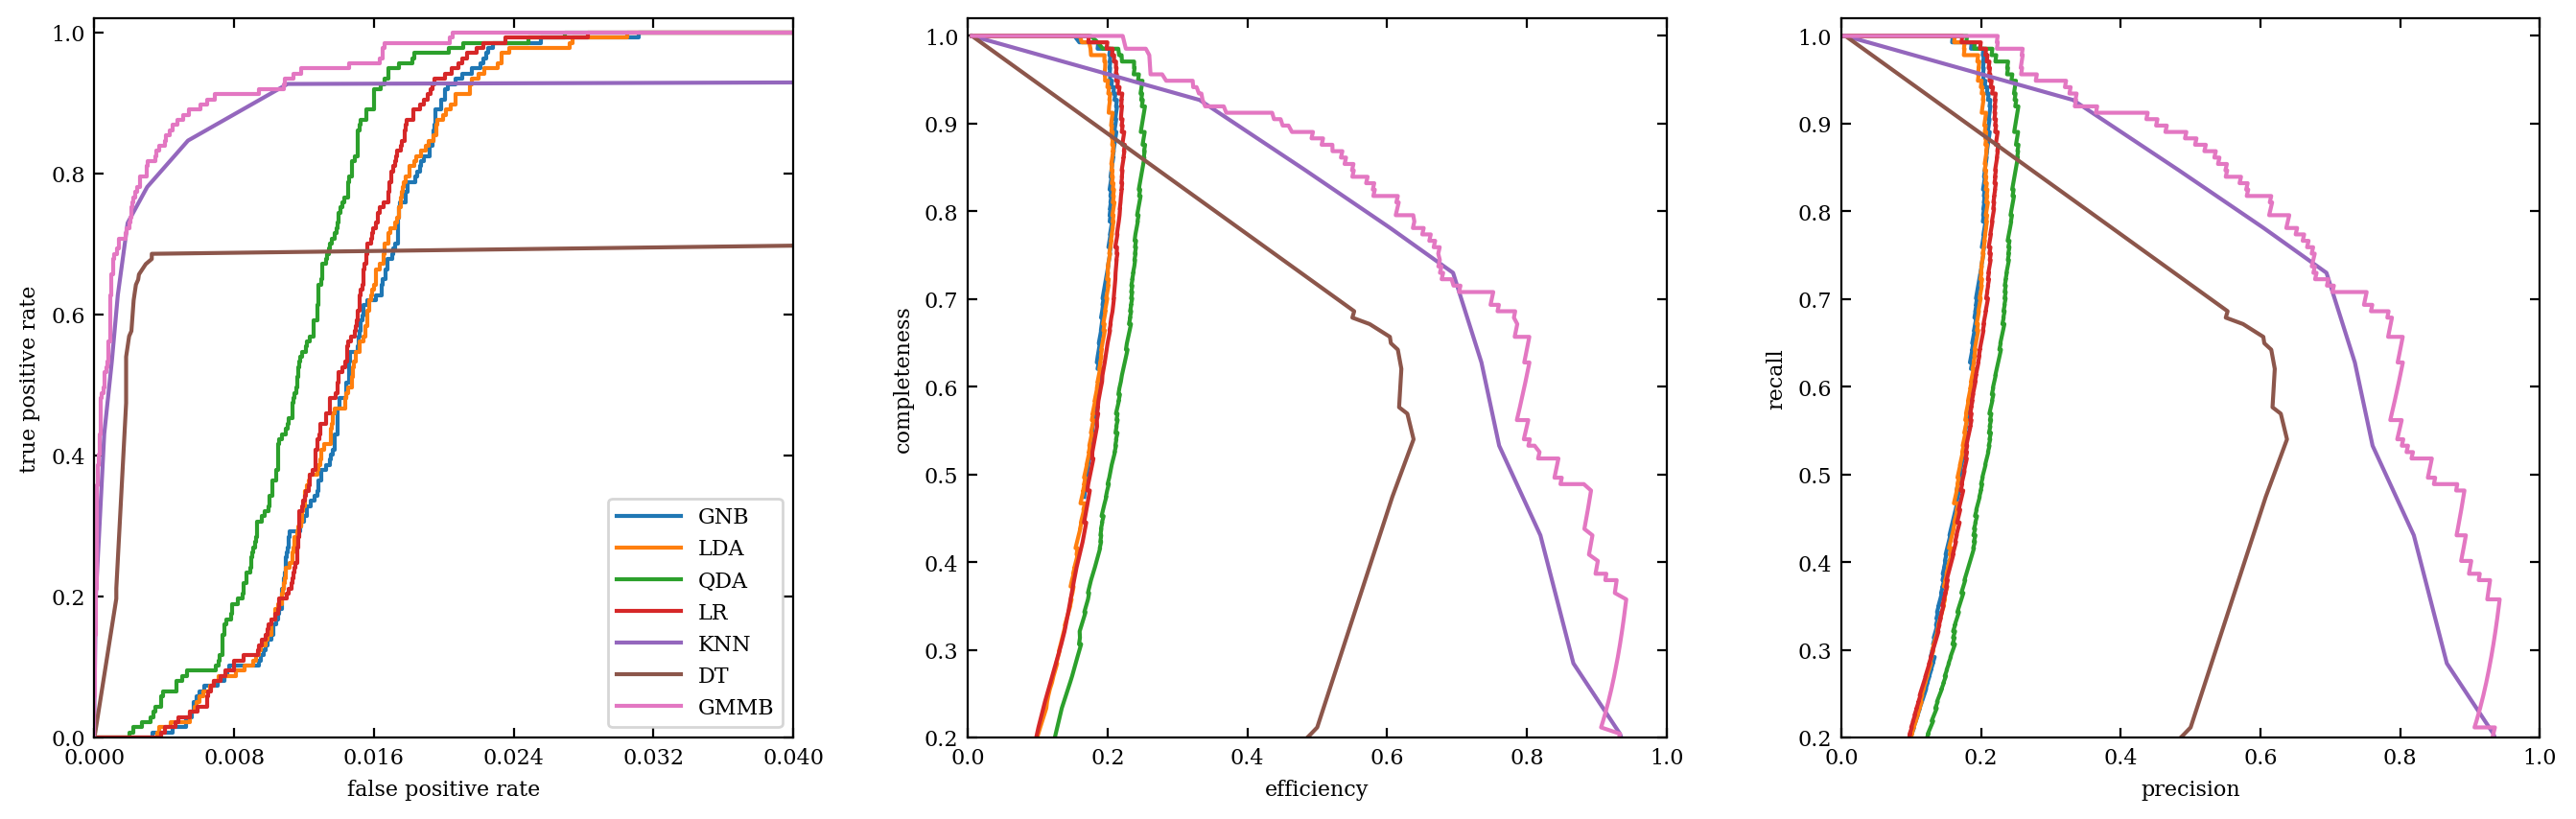

In [3]:
# Ivezic v2, Figure 9.17, edits by GTR
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function

import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from astroML.classification import GMMBayes

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from astroML.utils import split_samples, completeness_contamination
from astroML.datasets import fetch_rrlyrae_combined

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
y = y.astype(int)
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)


#------------------------------------------------------------
# Fit all the models to the training data
def compute_models(*args):
    names = []
    probs = []
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)
        
        #Note that we are outputing the probabilities [of class 1], not the classes
        y_probs = clf.predict_proba(X_test)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs


names, probs = compute_models((GaussianNB, {}),
                              (LinearDiscriminantAnalysis, {}),
                              (QuadraticDiscriminantAnalysis, {}),
                              (LogisticRegression,
                               dict(class_weight='balanced')),
                              (KNeighborsClassifier,
                               dict(n_neighbors=10)),
                              (DecisionTreeClassifier,
                               dict(random_state=0, max_depth=12,
                                    criterion='entropy')),
                              (GMMBayes, dict(n_components=3, tol=1E-5,
                                              covariance_type='full')))

#------------------------------------------------------------
# Plot ROC curves and completeness/efficiency
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# ax1 will show roc curves
ax1 = plt.subplot(131)

# ax2 will show completeness/efficiency
ax2 = plt.subplot(132)

# ax3 will show precision/recall
ax3 = plt.subplot(133)

labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR')

thresholds = np.linspace(0, 1, 1001)[:-1]

# iterate through and show results
for name, y_prob in zip(names, probs):
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])

    ax1.plot(fpr, tpr, label=labels[name])

    #See note above about astroML vs. sklearn
    #Note that the range of threshhold values here is 0% to 100% (0.0 to 1.0)
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred = (y_prob >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)
    ax2.plot(1 - cont, comp, label=labels[name])
    
    ax3.plot(precision, recall, label=labels[name])

ax1.set_xlim(0, 0.04)
ax1.set_ylim(0, 1.02)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.legend(loc=4)

ax2.set_xlabel('efficiency')
ax2.set_ylabel('completeness')
ax2.set_xlim(0, 1.0)
ax2.set_ylim(0.2, 1.02)

ax3.set_xlabel('precision')
ax3.set_ylabel('recall')
ax3.set_xlim(0, 1.0)
ax3.set_ylim(0.2, 1.02)

plt.show()

Note that I've plotted both recall-precision and completeness-efficiency just to demonstrate that they are the same thing.

The plot below shows the values of precision and recall as a function of the threshold value, highlighting the value where precision is 90%.

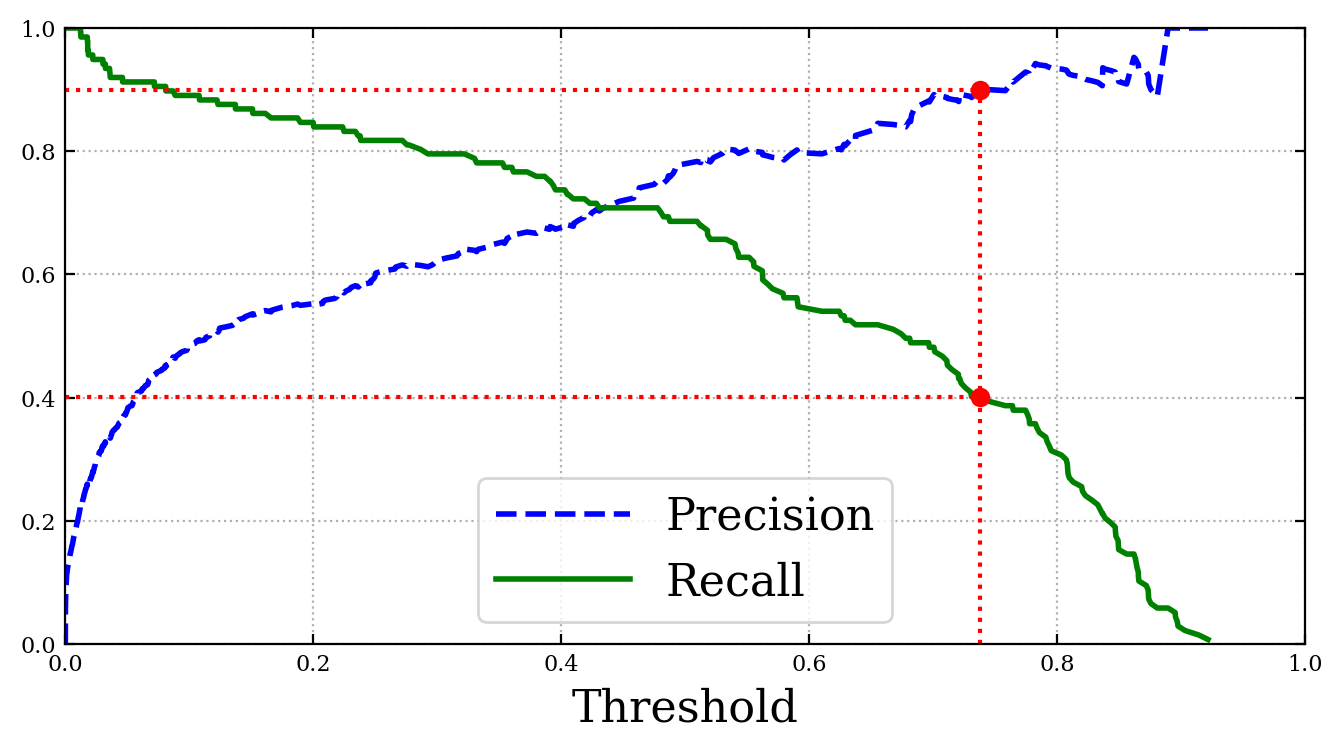

In [4]:
#From Geron
#Uses the values of precisions, recalls, and thresholds from above
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)                
    plt.axis([0, 1, 0, 1])             

recall_90_precision = recall[np.argmax(precision >= 0.90)]
threshold_90_precision = thresh2[np.argmax(precision >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precision, recall, thresh2)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([0, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([0, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
#save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

Now we'll look at the same in terms of completeness and contamination.  While these are the same as recall and precision, their calculation is slightly different (using either sklearn or astroML).

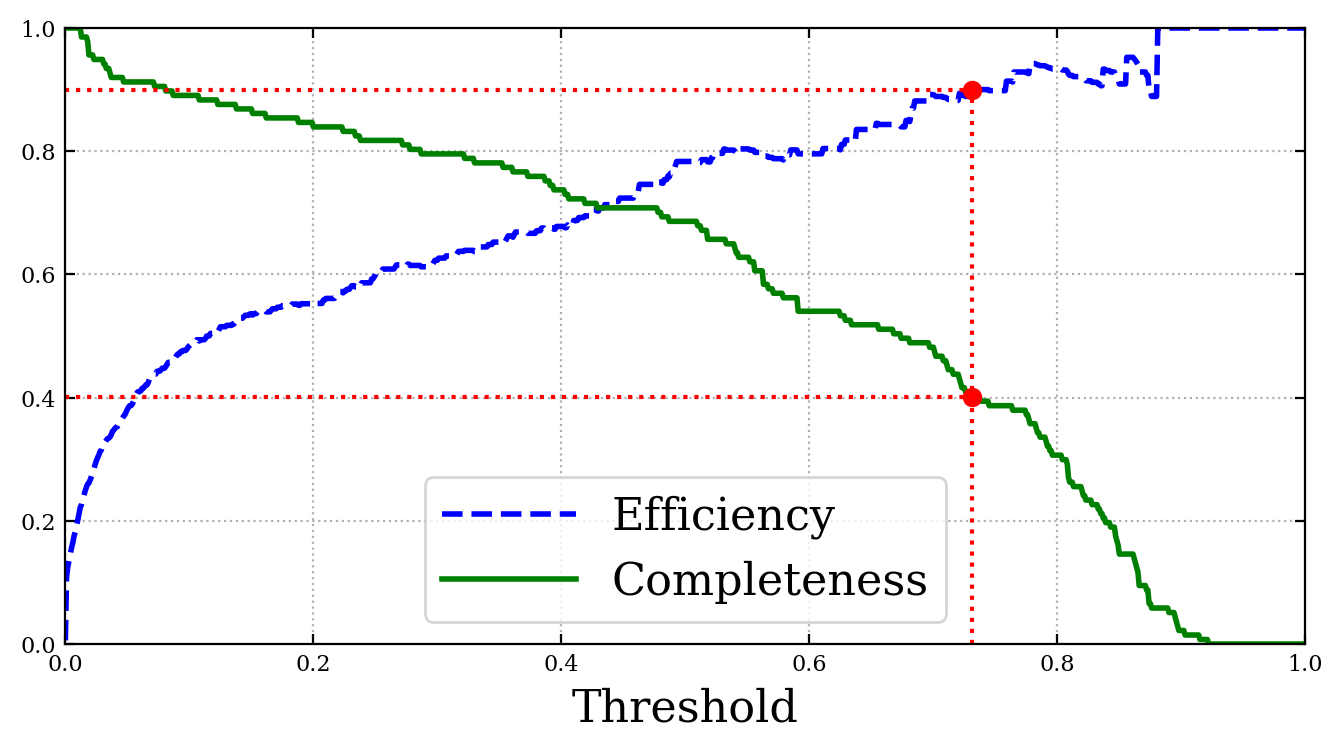

In [5]:
eff = 1-cont
def plot_comp_eff_vs_threshold(eff, comp, thresholds):
    plt.plot(thresholds, eff, "b--", label="Efficiency", linewidth=2)
    plt.plot(thresholds, comp, "g-", label="Completeness", linewidth=2)
    plt.legend(loc="best", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)                
    plt.axis([0, 1, 0, 1])             

comp_90_eff = comp[np.argmax(eff >= 0.90)]
threshold_90_eff = thresholds[np.argmax(eff >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  
plot_comp_eff_vs_threshold(eff, comp, thresholds)
plt.plot([threshold_90_eff, threshold_90_eff], [0., 0.9], "r:")                 
plt.plot([0, threshold_90_eff], [0.9, 0.9], "r:")                                
plt.plot([0, threshold_90_eff], [comp_90_eff, comp_90_eff], "r:")
plt.plot([threshold_90_eff], [0.9], "ro")                                             
plt.plot([threshold_90_eff], [comp_90_eff], "ro")                                                                          
plt.show()

Finally, here's how to visualize a constraint on precision (in terms of what it means for recall) in our precision-recall plot.

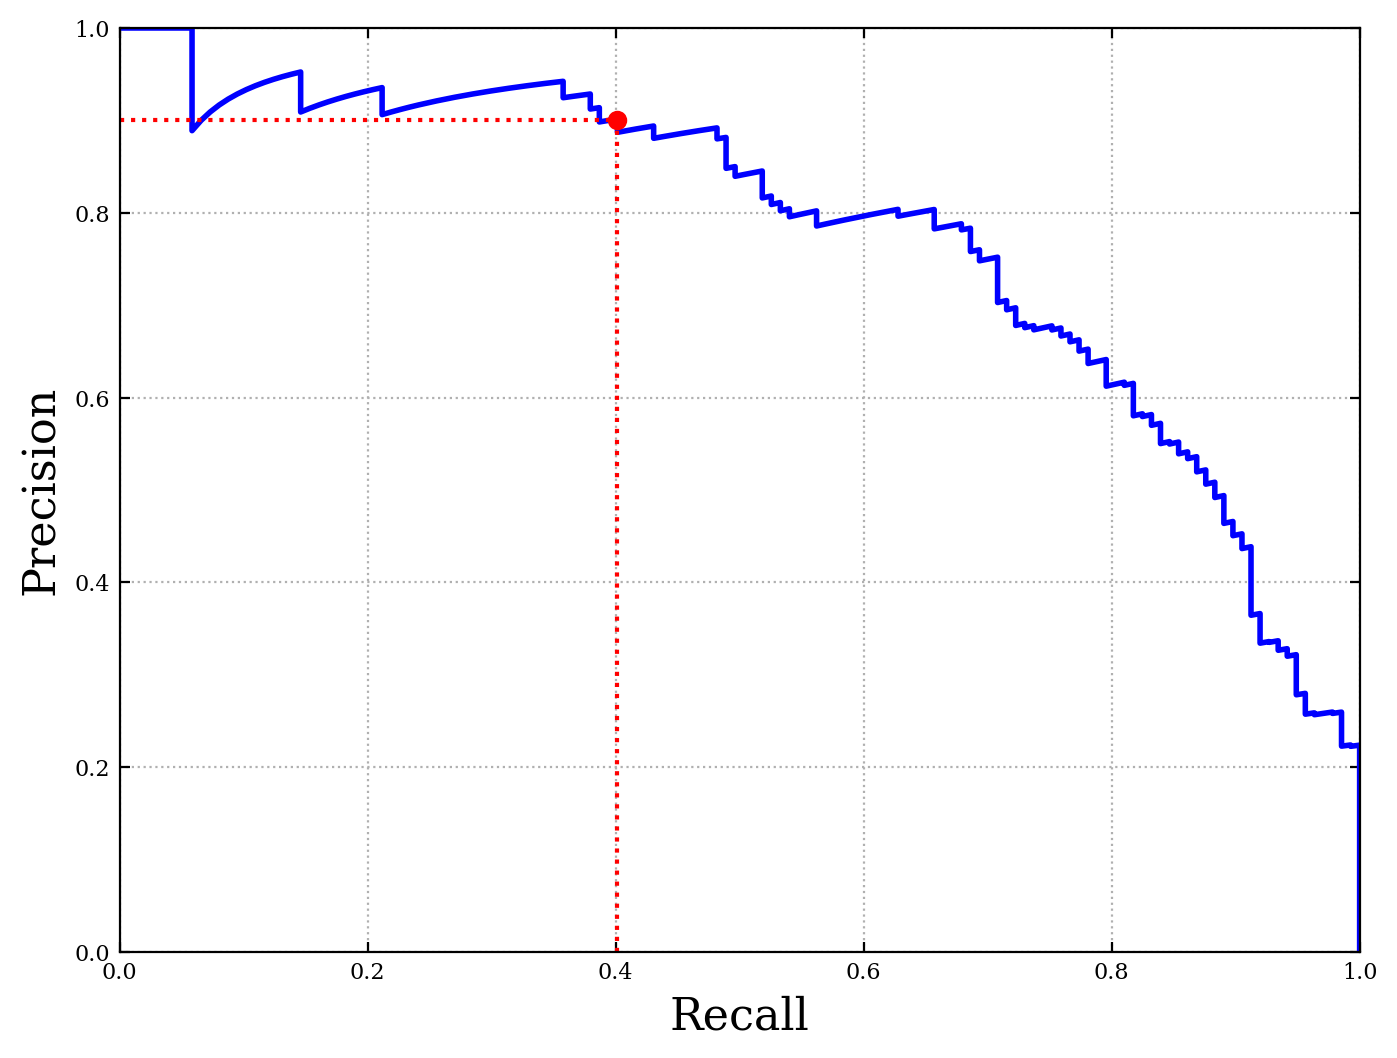

In [6]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

    
recall_90_precision = recall[np.argmax(precision >= 0.90)]
threshold_90_precision = thresh2[np.argmax(precision >= 0.90)]

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precision, recall)
#plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([recall_90_precision,recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot(recall_90_precision, [0.9], "ro")
#save_fig("precision_vs_recall_plot")
plt.show()

So far we have only looked at binary classification.  However, you may instead want:

* [Multiclass](https://scikit-learn.org/stable/modules/multiclass.html): to distinguish between more than 2 classes (e.g., MNIST digits)

* [Multilabel](https://scikit-learn.org/stable/modules/multiclass.html): if you want to allow multiple class labels for each object

But those are beyond the scope of what we'll see this week.

## Generative Classification <a class="anchor" id="three"></a>

With some assessment criteria defined, we can talk about classification itself.  **We can use Bayes' theorem to relate the labels to the features in an $N\times D$ data set $X$.**  The $j$th feature of the $i$th point is $x^j_i$ and there are $k$ classes giving discrete labels $y_k$.  We have

$$p(y_k|x_i) = \frac{p(x_i|y_k)p(y_k)}{\sum_i p(x_i|y_k)p(y_k)},$$

where $x_i$ is assumed to be a vector with $j$ components.

$p(y=y_k)$ is the probability of any point having class $k$ (equivalent to the prior probability of the class $k$). 

In generative classifiers we model class-conditional densities $p(x|y=y_k)$. 

Before we get into the generative classification algortithms, we'll first discuss 3 general concepts:
- (a) Discriminant Functions
- (b) Bayes Classifiers
- (c) Decision Boundaries

### (a) The Discriminant Function

**We can relate classification to density estimation and regression**. $\hat{y} = f(y|x)$ represents the best guess of $y$ given $x$. **So classification is just regression with discrete $y$ values, e.g., $y=\{0,1\}$.**

In classification we refer to $f(y|x)$ as the [**discriminant function**](https://en.wikipedia.org/wiki/Discriminant_function_analysis).

For a simple 2-class example, where $y=\{0,1\}$:

$$\begin{aligned}
g(x) = f(y|x) &=  \int y \, p(y|x) \, dy \\
%    & = & \int y p(y|x) \, dy \\
       &= 1 \cdot p(y=1 | x) + 0 \cdot p(y=0 | x) = p(y=1 | x).
%     & = & p(y=1 | x)
\end{aligned}
$$

and then using Bayes' rule:

$$g(x) = \frac{p(x|y=1) \, p(y=1)}{p(x|y=1) \, p(y=1)  + p(x|y=0) \, p(y=0)}$$

The first equation is just the expectation value of y.

### (b) Bayes Classifier

If the discriminant function gives a binary prediction, we call it a **Bayes classifier**, formulated as

$$\begin{eqnarray} \widehat{y} & = & \left\{ \begin{array}{cl}       	           1 & \mbox{if $g(x) > 1/2$}, \\       	           0 & \mbox{otherwise,}       	           \end{array}     	   \right. \\     & = & \left\{
\begin{array}{cl}               1 & \mbox{if $p(y=1|x) > p(y=0|x)$}, \\               0 & \mbox{otherwise.}               \end{array}       \right.\end{eqnarray}$$

Where this can be generalized to any number of classes, $k$, and not just two.

### (c) Decision Boundary

A **decision boundary** is just set of $x$ values at which each class is equally likely:

$$
p(x|y=1)p(y=1)  =  p(x|y=0)p(y=0);
$$

$$g_1(x) = g_2(x) \; {\rm or}\; g(x) = 1/2$$

Below is an example of a decision boundary in 1-D, where each class is equally likely so we can just look at $p(x)$.  In short, we assign classifications according to which pdf is higher at every given $x$.

![Ivezic, Figure 9.1](http://www.astroml.org/_images/fig_bayes_DB_1.png)


## Simplest Classifier: Naive Bayes <a class="anchor" id="four"></a>

In practice, classification is complicated as the data are generally multi-dimensional (that is we don't just have $x$, we have $x^{j=0},x^1,x^2,x^3...x^N$, so we want $p(x^0,x^1,x^2,x^3...x^N|y)$.

Naive Bayes classification comes to the rescue here: note that it's not very clearly in the textbook section that this is for discrete features $\{x\}$. If we **assume** that ***all attributes are conditionally independent*** (which is not always true, but is often close enough), then multi-dimensional pdfs simplify to

$$ p(x^i,x^j|y_k) = p(x^i|y)p(x^j|y_k)$$
  
which can be written as

$$ p({x^{j=0},x^1,x^2,\ldots,x^N}|y_k) = \prod_j p(x^j|y_k).$$

From Bayes' rule and conditional independence we get

$$
  p(y_k | {x^0,x^1,\ldots,x^N}) =
  \frac{\prod_j p(x^j|y_k) p(y_k)}
       {\sum_l \prod_j p(x^j|y_l) p(y_l)}.
$$

We calculate the most likely value of $y$ by maximizing this over choices of $y_k$:

$$
\hat{y} = \arg \max_{y_k} \frac{\prod_j p(x^j|y_k) p(y_k)}
        {\sum_l \prod_j p(x^j|y_l) p(y_l)},
$$


From there the process is just estimating densities: $p(x|y=y_k)$ and $p(y=y_k)$ are learned from a set of training data, where
- **$p(y=y_k)$ is just the frequency of the class $k$ in the training set**
- **$p(x|y=y_k)$ is just the density (probability) of an object with class $k$ having the attributes $x$**

## Gaussian Naive Bayes <a class="anchor" id="five"></a>

One way to handle continuous values for $X$ is to model $p(x^j|y=y_k)$ as one-dimensional normal distributions, with means $\mu^j_k$ and widths $\sigma^j_k$. The naive Bayes estimator is then

$$\hat{y} = \arg\max_{y_k}\left[\ln p(y=y_k) - \frac{1}{2}\sum_{j=1}^N\left(2\pi(\sigma^j_k)^2 + \frac{(x^j - \mu^j_k)^2}{(\sigma^j_k)^2} \right) \right]$$

In Scikit-Learn [`Gaussian Naive Bayes`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) classification is implemented as follows, with a simple example given in the next cell.

In [7]:
import numpy as np
from sklearn.naive_bayes import GaussianNB

X = np.random.random((100,2))
y = (X[:,0] + X[:,1] > 1).astype(int) #Class 1 if sum of both features is >1

gnb = GaussianNB()
gnb.fit(X,y)

y_pred = gnb.predict(X)

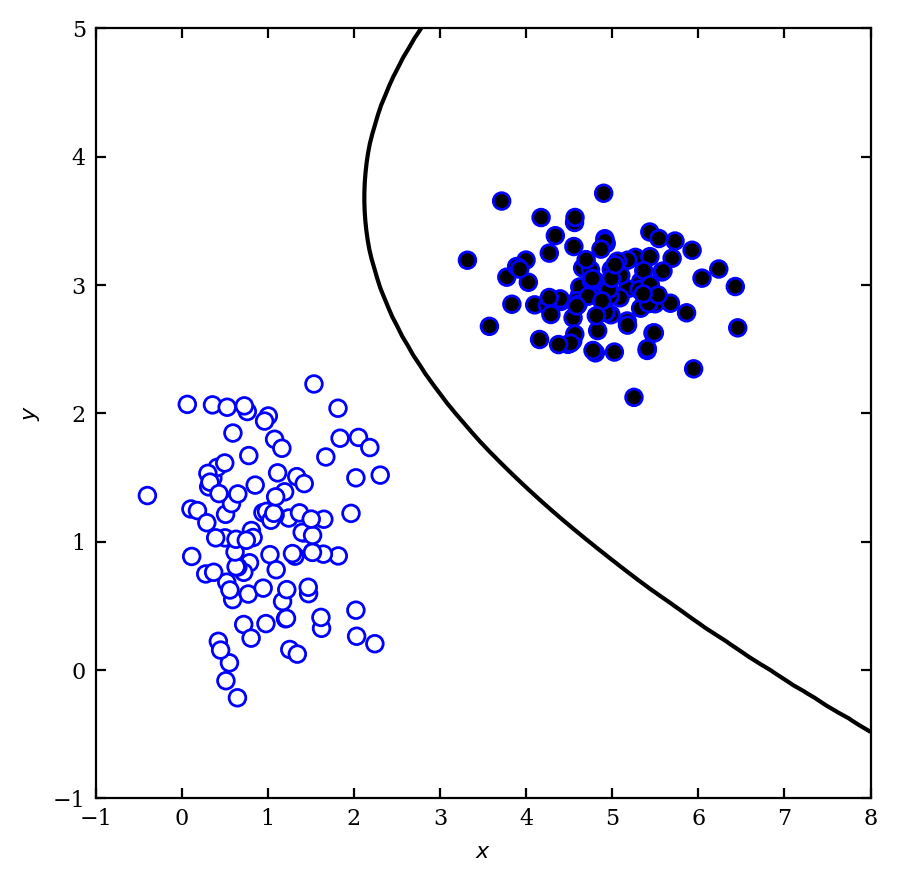

In [8]:
# Ivezic v2, Figure 9.2, edits by GTR and SRT
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib import colors

from sklearn.naive_bayes import GaussianNB

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Simulate some data
np.random.seed(0)
mu1 = [1, 1]
cov1 = 0.3 * np.eye(2)

mu2 = [5, 3]
cov2 = np.eye(2) * np.array([0.4, 0.1])

X = np.concatenate([np.random.multivariate_normal(mu1, cov1, 100),
                    np.random.multivariate_normal(mu2, cov2, 100)])
y = np.zeros(200)
y[100:] = 1

#------------------------------------------------------------
# Fit the Naive Bayes classifier
clf = GaussianNB()
clf.fit(X, y)

# predict the classification probabilities on a grid
xlim = (-1, 8)
ylim = (-1, 5)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
# Gives probability for both class 1 and class 2 for each grid point
# As these are degenerate, take just one and then
# re-shape it to the grid pattern needed for contour plotting
Z = Z[:, 1].reshape(xx.shape)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary, zorder=2)


# Add the decision boundary, which is just the contour where
# the probability exceeds some threshold, here 0.5.
ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

**And now an example using real data-- this uses Gaussian Naive Bayes classification to separate RR Lyrae stars from non-variable main squence stars.** Here we have a 4-D $X$ and we are going to take them 1-D at a time to see how much improvement comes from adding each new dimension of $X$.

completeness [0.48175182 0.68613139 0.81021898 0.87591241]
contamination [0.85201794 0.79295154 0.80143113 0.79020979]


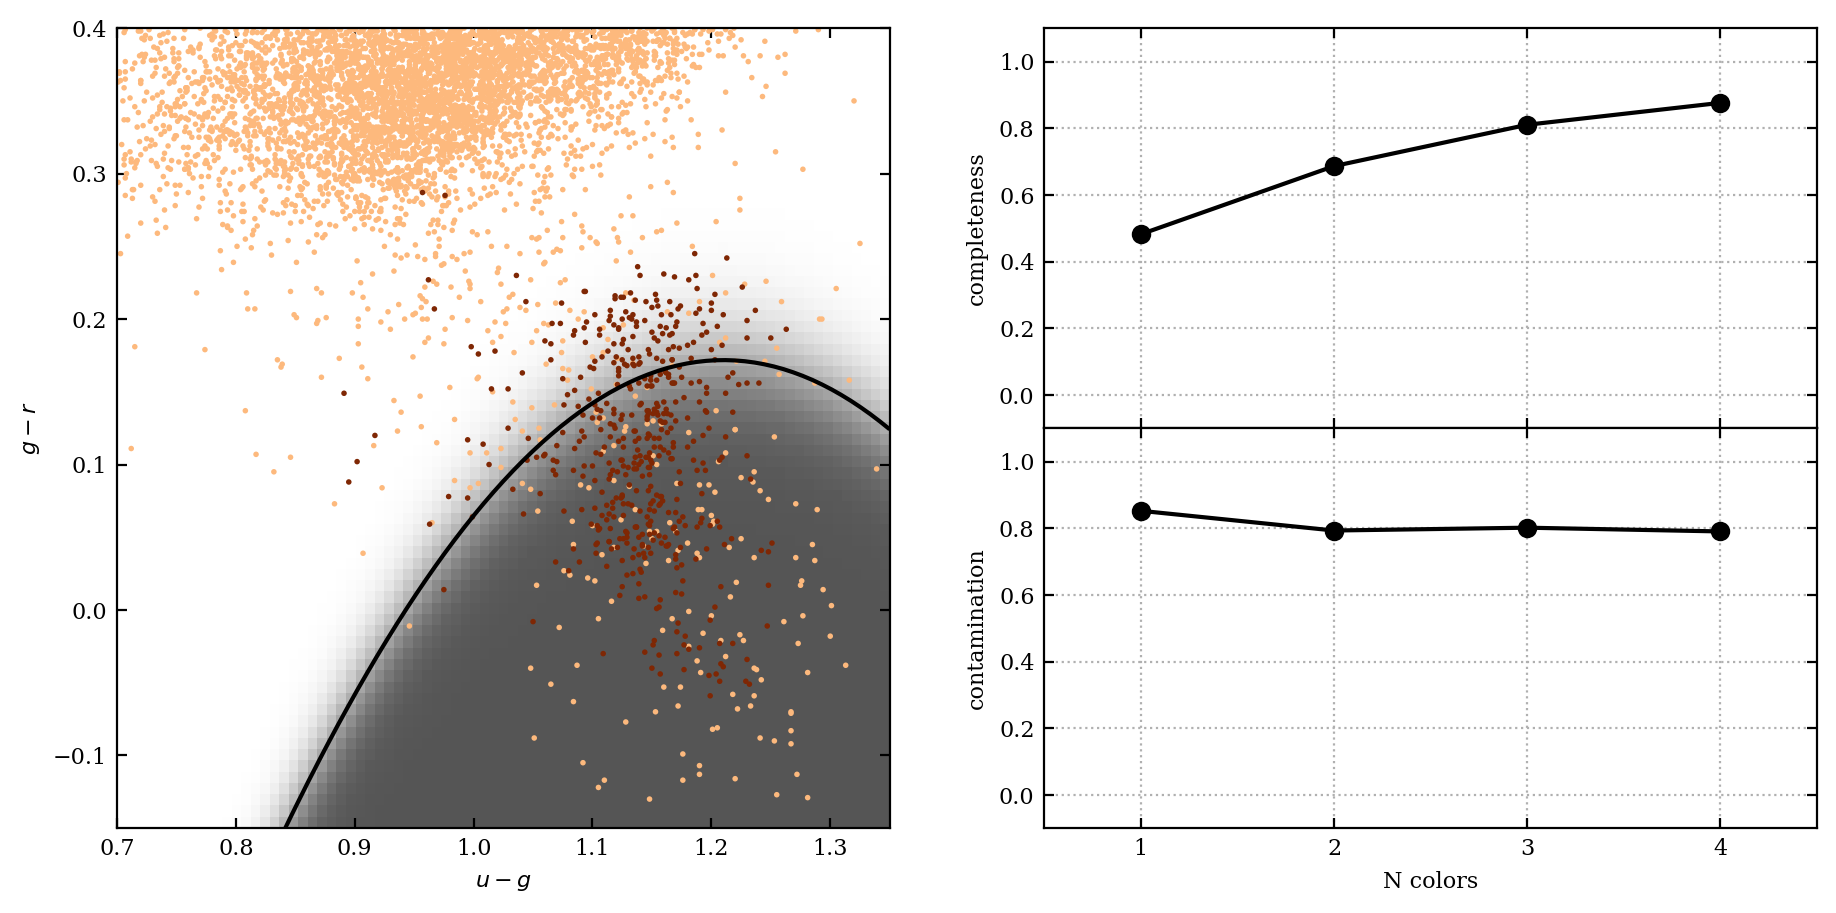

In [9]:
# Ivezic v2, Figure 9.3, edits by GTR and SRT
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from sklearn.naive_bayes import GaussianNB
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
# Added by GTR
from sklearn.metrics import precision_recall_curve, roc_curve

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined() # X is a 4-D color-color-color-color space
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform Naive Bayes
classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

order = np.array([1, 0, 2, 3])

y_prob = np.array([])

for nc in Ncolors:
    clf = GaussianNB()
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])
    
    # Added by GTR to be able to compute precision, recall, fpr, and tpr
    # Gives the probability for both classes, take just one
    y_prob = np.append(y_prob,clf.predict_proba(X_test[:, :nc])[:,1])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)
ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# Plot completeness vs Ncolors
ax = plt.subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# Plot contamination vs Ncolors
ax = plt.subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

- In the **left panel**, peach points represent non-variable sources, while dark grey points are variable sources. The decision boundary is a curved black line, with the classification porbability shown as a shaded background.
- In the **right panel**, more and more stellar color features are used to train the classification scheme. 

<font color='red'>If you shifted the decision boundary "up" by hand, discuss with your classmates what would happen to the completeness, contamination, and false positive rate? What happens if you change the fraction of objects in the training set?</font>

Answer: Depending on how much we move it up, we can get a much better ratio of true positives to false positives. This improvement falls off quick as we start catching more of those false negatives.


The "*naive*" in Naive Bayes refers to the fact that we are assuming that all of the variables are conditionally independent. If we relax that assumption and allow for covariances, then we have a **Gaussian Bayes classifier**.  But note that this comes with a large jump in computational cost! Recall the form of a multivariate Gaussian distribution, where $\vec{x}$ and $\vec{\mu}_k$ are $D$-dimensional vectors over data features, and $\Sigma_k$ is a $D\times D$ symmetric covariance matrix:

$$ p_k(\vec{x}) = \frac{1}{\sqrt{\mathrm{det}(2\pi\Sigma_k)}}\exp\left[ -\frac{1}{2}(\vec{x}-\vec{\mu}_k)^T \Sigma_k^{-1}(\vec{x}-\vec{\mu}_k) \right].$$

**The Gaussian Bayes classifier version of $\hat{y}$ is then**

$$\hat{y} = \arg\max_{y_k}\left[\ln p(y=y_k) - \frac{1}{2}\ln\mathrm{det}(\Sigma_k) - \frac{1}{2}(\vec{x}-\vec{\mu}_k)^T \Sigma_k^{-1}(\vec{x}-\vec{\mu}_k)\right]$$

## Linear & Quadratic Discriminant Analysis <a class="anchor" id="six"></a>

In **[Linear Discriminant Analysis (LDA)](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)** we simplify the Gaussian Bayes classifier by assuming that the class distributions have ***identical***
covariances for all $k$ classes (all classes are a set of shifted Gaussians). 

**If we ignore terms involving only the data, $X$, and the class-dependent covariances, then this cancels out terms that have quadratic dependence on $X$.** The log of the class posteriors

$$ g_k(\vec{x}) = \vec{x}^T \Sigma^{-1} \vec{\mu_k} - \frac{1}{2}\vec{\mu_k}^T \Sigma^{-1} \vec{\mu_k} + \ln p(y=y_k),$$

with $\vec{\mu}_k$ the mean of class $k$ and $\Sigma_k$ the covariance of the Gaussians.

<!--- ** note different from book --->

***The Bayes classifier is, therefore, linear with respect to $X$***, and  discriminant boundary between classes is the line that minimizes the overlap between Gaussians.

<!--- > $  g_k(\vec{x}) - g_\ell(\vec{x}) = \vec{x}^T \Sigma^{-1} (\mu_k-\mu_\ell)  - \frac{1}{2}(\mu_k - \mu_\ell)^T \Sigma^{-1}(\mu_k -\mu_\ell)  + \log (\frac{\pi_k}{\pi_\ell}) = 0. $ --->

**Relaxing the requirement that the covariances of the Gaussians are equal, the discriminant function becomes quadratic in $X$.**

$$ g(\vec{x}) = -\frac{1}{2} \ln\mathrm{det}(\Sigma_k) - \frac{1}{2}(\vec{x}-\mu_k)^T \Sigma_k^{-1}(\vec{x}-\mu_k) + \ln p(y=y_k). $$

This is sometimes known as **[Quadratic Discriminant Analysis (QDA)](https://en.wikipedia.org/wiki/Quadratic_classifier#Quadratic_discriminant_analysis)**.

[`LDA`](http://scikit-learn.org/0.16/modules/generated/sklearn.lda.LDA.html) and [`QDA`](http://scikit-learn.org/0.16/modules/generated/sklearn.qda.QDA.html#sklearn.qda.QDA) are implemented in `Scikit-Learn` as follows and an example using the same data as above is given below.

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

X = np.random.random((100,2))
y = (X[:,0] + X[:,1] > 1).astype(int)

lda = LDA()
lda.fit(X,y)
y_pred = lda.predict(X)

qda = QDA()
qda.fit(X,y)
y_pred = qda.predict(X)

completeness 0.6715328467153284 0.6861313868613139
contamination 0.8059071729957806 0.7924944812362031


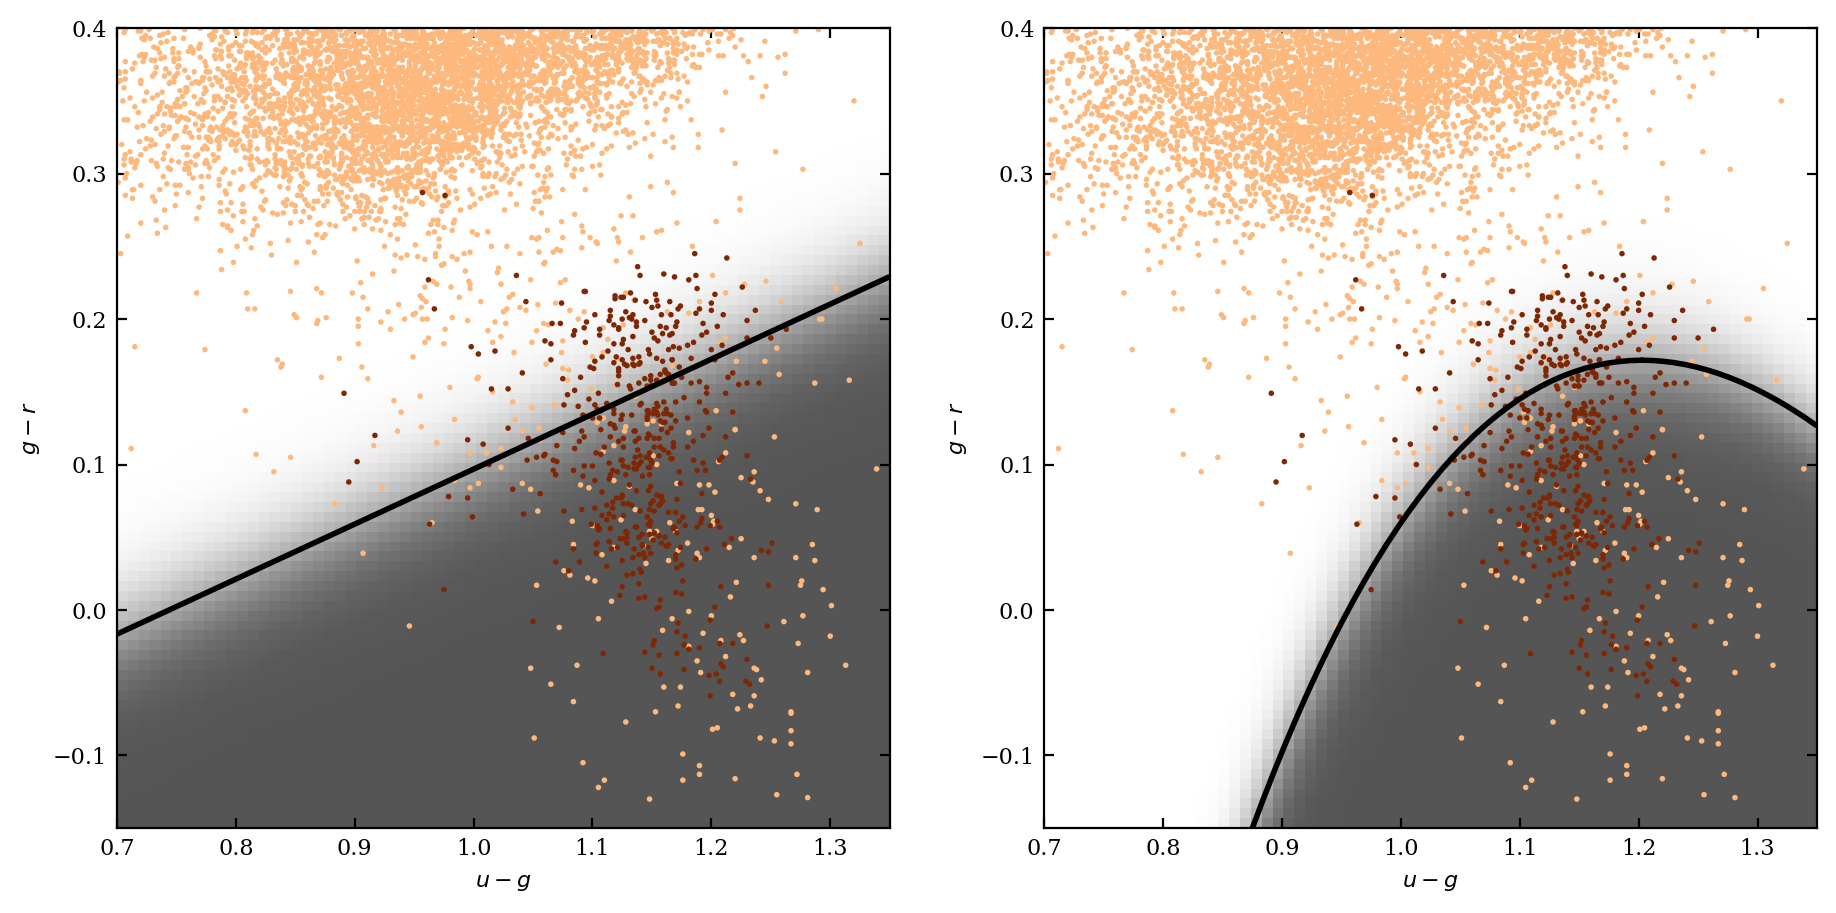

In [11]:
# Ivezic, Figures 9.4 and 9.5, spliced together by GTR

from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], 
                                                     random_state=0)

N_tot = len(y)
N_stars = np.sum(y == 0)
N_rrlyrae = N_tot - N_stars
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rrlyrae

#----------------------------------------------------------------------
# perform LDA
lda = LDA()
lda.fit(X_train[:, :2], y_train)
y_predLDA = lda.predict(X_test[:, :2])

# perform QDA
qda = QDA()
qda.fit(X_train[:, :2], y_train)
y_predQDA = qda.predict(X_test[:, :2])
    
completenessLDA, contaminationLDA = completeness_contamination(y_predLDA, y_test)
completenessQDA, contaminationQDA = completeness_contamination(y_predQDA, y_test)

print("completeness", completenessLDA, completenessQDA)
print("contamination", contaminationLDA, contaminationQDA)

#------------------------------------------------------------
# Compute the decision boundary
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z_LDA = lda.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z_LDA = Z_LDA[:, 1].reshape(xx.shape)
Z_QDA = qda.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z_QDA = Z_QDA[:, 1].reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z_LDA, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)

ax.contour(xx, yy, Z_LDA, [0.5], linewidths=2., colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# right plot: qda
ax = fig.add_subplot(122)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z_QDA, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)

ax.contour(xx, yy, Z_QDA, [0.5], linewidths=2., colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

plt.show()

If it is obvious from looking at your data that a linear or quadratic boundary will work well, then great.  But what if that is not the case?

## GMM and Bayes Classification <a class="anchor" id="seven"></a>

Our classifications so far have made some restrictive assumptions. Either
- conditional independence, or 
- Gaussianity of the distributions.  

However, a more flexible model might improve the completeness and efficiency of the classification. For that we can look to the **density estimation techniques** from Chapter 6.

The natural extension of the Gaussian assumptions is to use GMM's (Gaussian Mixture Models) to determine the density distribution, i.e., a **GMM Bayes Classifier**. Note that the number of Gaussian components, $K$, must be chosen for each class, $k$, independently.

`astroML` implements GMM Bayes classification as:

In [12]:
from astroML.classification import GMMBayes
#from astroML.classification import GaussianMixture as GMMBayes

X = np.random.random((100,2))
y = (X[:,0] + X[:,1] > 1).astype(int)

gmmb = GMMBayes(3) # 3 clusters per class
gmmb.fit(X,y)

y_pred = gmmb.predict(X)

We now apply the GMM Bayes classifier to the real stellar data from above. ***With just one component, we get results that are similar to those from Naive Bayes. But with 5 components (and all 4 attributes), we do pretty well.***

@pickle_results: computing results and saving to 'GMMbayes_rrlyrae.pkl'


c:\Users\tonyt\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\tonyt\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\tonyt\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
c:\Users\tonyt\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converg

completeness [[0.48175182 0.68613139 0.73722628 0.78832117]
 [0.         0.         0.34306569 0.62043796]]
contamination [[0.85201794 0.79249448 0.77605322 0.75675676]
 [0.         0.         0.12962963 0.23423423]]


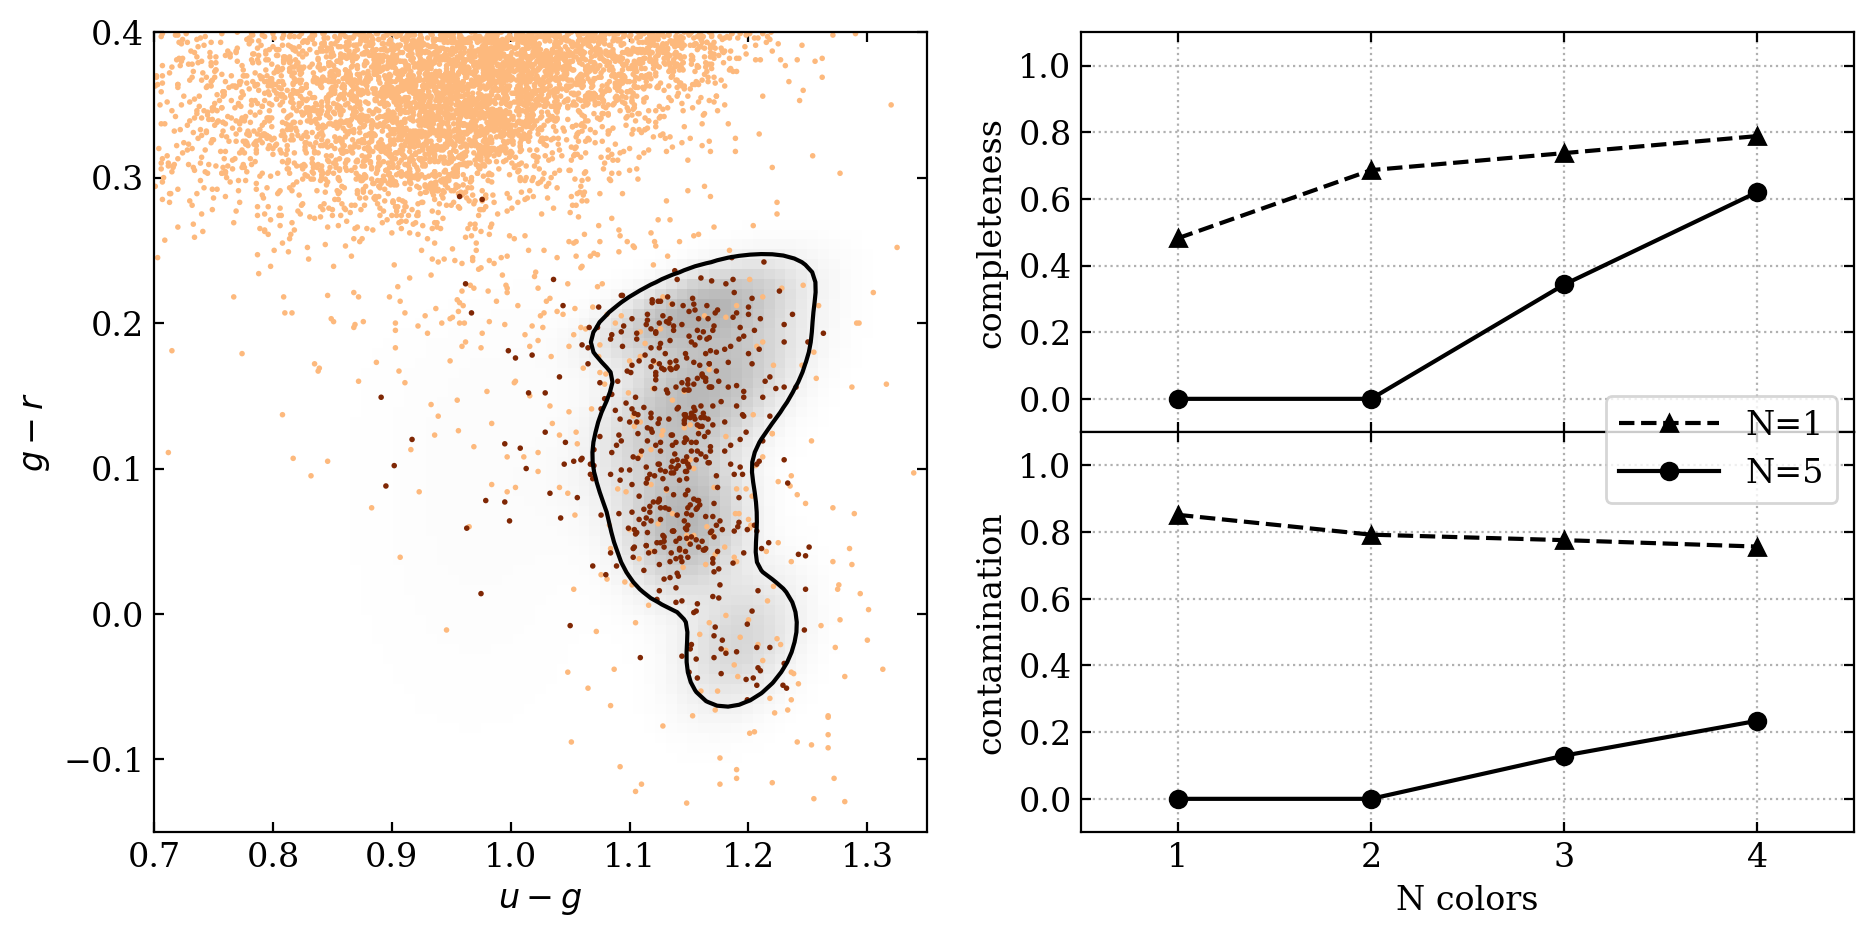

In [13]:
# Ivezic v2, Figure 9.6, edits by GTR and SRT
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from astroML.classification import GMMBayes
from astroML.utils.decorators import pickle_results
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=False)


#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results

# GMM-bayes takes several minutes to run, and is order[N^2]
#  truncating the dataset can be useful for experimentation.
#X = X[::10]
#y = y[::10]

(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)
N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform GMM Bayes
Ncolors = np.arange(1, X.shape[1] + 1)
Ncomp = [1, 5]


@pickle_results('GMMbayes_rrlyrae.pkl')
def compute_GMMbayes(Ncolors, Ncomp):
    classifiers = []
    predictions = []

    for ncm in Ncomp:
        classifiers.append([])
        predictions.append([])
        for nc in Ncolors:
            clf = GMMBayes(ncm, tol=1E-5, covariance_type='full')
            clf.fit(X_train[:, :nc], y_train)
            y_pred = clf.predict(X_test[:, :nc])

            classifiers[-1].append(clf)
            predictions[-1].append(y_pred)

    return classifiers, predictions

classifiers, predictions = compute_GMMbayes(Ncolors, Ncomp)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)

ax.contour(xx, yy, Z, [0.1], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness[0], '^--k', ms=6, label='N=%i' % Ncomp[0])
ax.plot(Ncolors, completeness[1], 'o-k', ms=6, label='N=%i' % Ncomp[1])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], '^--k', ms=6, label='N=%i' % Ncomp[0])
ax.plot(Ncolors, contamination[1], 'o-k', ms=6, label='N=%i' % Ncomp[1])
ax.legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.78))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

**NOTE:** We can take this to the extreme by having one mixture component at each training point. We also don't have to restrict ourselves to a Gaussian kernel, we can use any kernel that we like. The resulting ***non-parametric*** Bayes classifier is referred to as **Kernel Discriminant Analysis (KDA)**. 

It seems like this would be a *lot* more computationally intensive, but now we don't have to optimize the locations of the components...we just need to determine the bandwidth of the kernel. In the end, it can result in better classification.

One of the tricks to speed things up is that we don't need to know the actually class probability, we just need to know which is larger.  This is explained in more detail in [Riegel, Gray, & Richards 2008](http://epubs.siam.org/doi/abs/10.1137/1.9781611972788.19), and it is implemented in a series of papers starting with [Richards et al. 2004](http://adsabs.harvard.edu/abs/2004ApJS..155..257R).  

## K-Nearest Neighbor Classifier <a class="anchor" id="eight"></a>

If we did KDA with a variable bandwidth that depended only on the distance of the nearest neighbor, then we'd have what we call a **Nearest-Neighbor** classifier. Here if $x$ is close to $x'$, then $p(y|x) \approx p(y|x')$, i.e. **we use the class label of the nearest point**. Note that we have not assumed anything about the conditional density distribution, so it is completely non-parametric.

The number of neighbors, $K$, regulates the complexity of the classification, where a larger $K$ decreases the variance in the classification but leads to an increase in the bias. In the simplest form, a majority rule classification is adopted, where each of the $K$ neighbors votes on the classification (N.B., the 3rd different use of $K$ or $k$ in this notebook!)

The distance measure is usually N-dimensional Euclidean. However, if the attributes have very different properties, then normalization, weighting, etc. may be needed.

Scikit-learn implements **[`K-Nearest Neighbors`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) classification** as

In [14]:
from sklearn.neighbors import KNeighborsClassifier

X = np.random.random((100,2))
y = (X[:,0] + X[:,1] > 1).astype(int)

knc = KNeighborsClassifier(5) # use 5 nearest neighbors
knc.fit(X,y)

y_pred = knc.predict(X)

Implementing it for the same example as above shows that it isn't all that great for this particular case.  See below.  We probably need more training data to reduce the variance for it to work better.

completeness [[0.13868613 0.3649635  0.46715328 0.54014599]
 [0.00729927 0.24087591 0.37956204 0.54744526]]
contamination [[0.85606061 0.54954955 0.44347826 0.41732283]
 [0.88888889 0.44067797 0.23529412 0.25      ]]


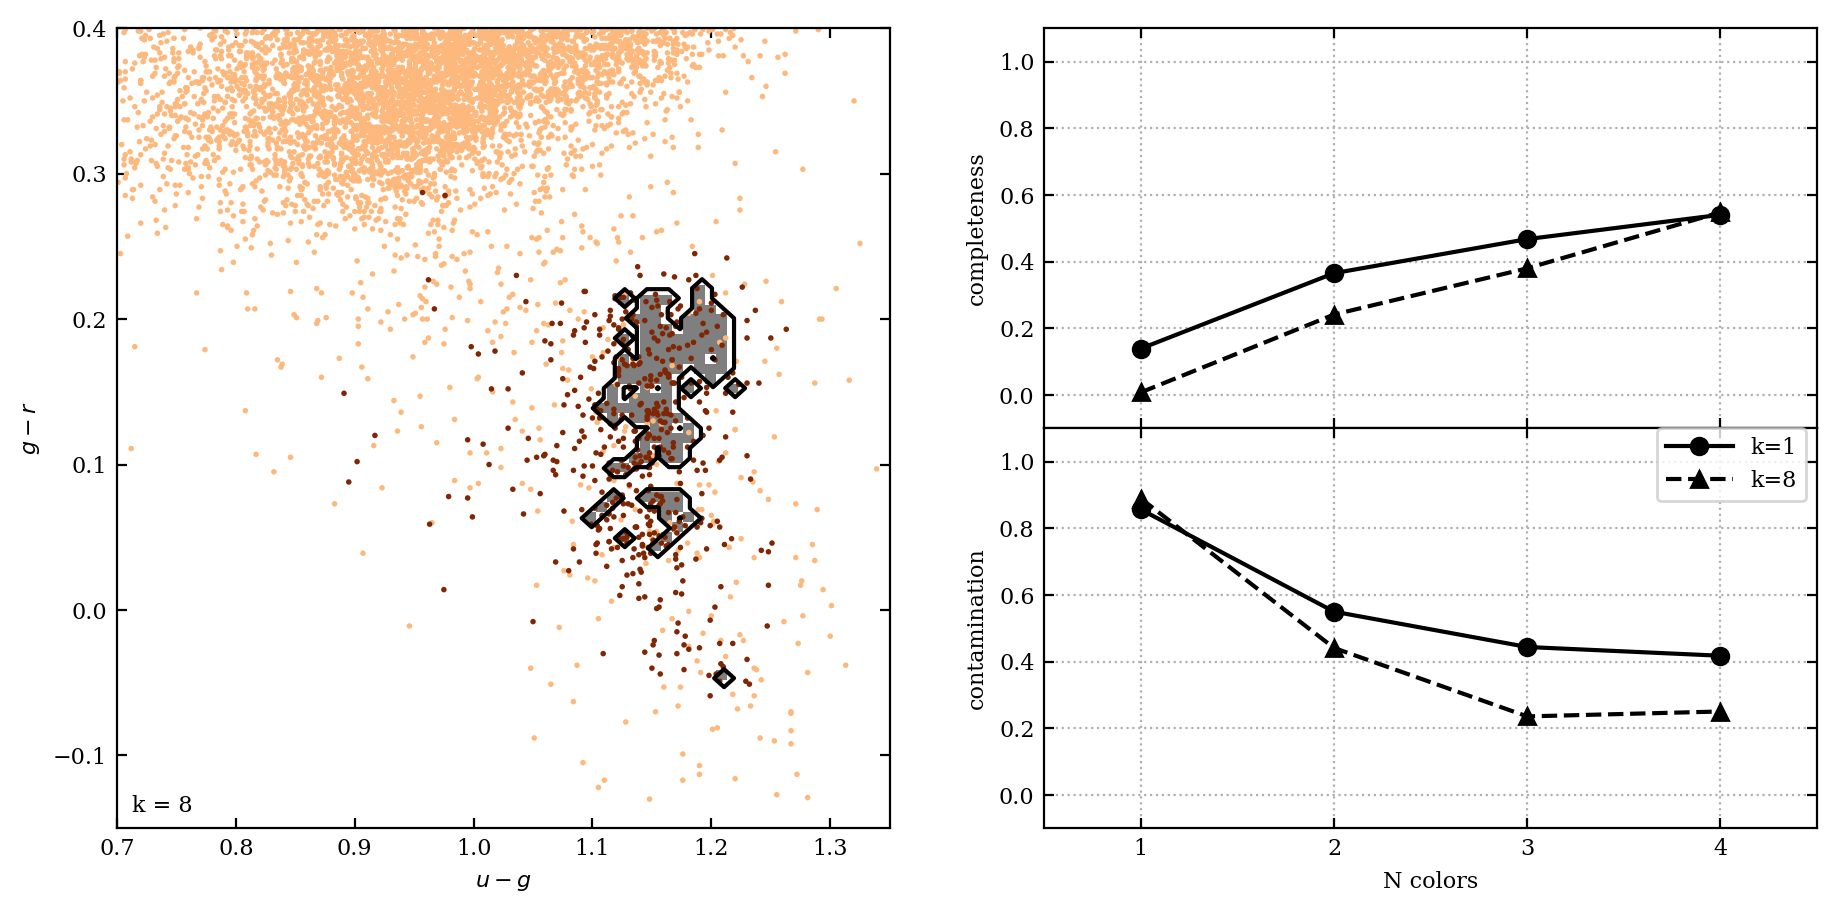

In [15]:
# Ivezic v2, Figure 9.7, edits by GTR
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from sklearn.neighbors import KNeighborsClassifier
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform Classification

classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)
kvals = [1, 8]

for k in kvals:
    classifiers.append([])
    predictions.append([])
    for nc in Ncolors:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 2)

ax.contour(xx, yy, Z, [0.1], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

ax.text(0.02, 0.02, "k = %i" % kvals[1],
        transform=ax.transAxes)

# plot completeness vs Ncolors
ax = fig.add_subplot(222)

ax.plot(Ncolors, completeness[0], 'o-k', ms=6, label='k=%i' % kvals[0])
ax.plot(Ncolors, completeness[1], '^--k', ms=6, label='k=%i' % kvals[1])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], 'o-k', ms=6, label='k=%i' % kvals[0])
ax.plot(Ncolors, contamination[1], '^--k', ms=6, label='k=%i' % kvals[1])
ax.legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.79))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

$K=1$ is clearly terrible, but even $K=8$ is not that great. <font color='red'>Where do you think the decision to try $K=8$ came from? Before moving on, discuss with your classmates the strategy you would use.</font>

Answer: We discussed testing an array of numbers to see which one optimized it.

Regardless of whether this is the best algorithm or not, we can choose $K$ to minimize the classification error rate by using cross-validation. See below for how this is computed (may take a few minutes to run).

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import completeness_contamination

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results

#----------------------------------------------------------------------
# perform Classification
scores = []
kvals = np.arange(1,20)
for k in kvals:
    clf = KNeighborsClassifier(n_neighbors=k)
    CVpredk = cross_val_predict(clf, X, y)
    scores.append(accuracy_score(y, CVpredk)) 

max score is for k=8


Text(0, 0.5, 'Classification accuracy')

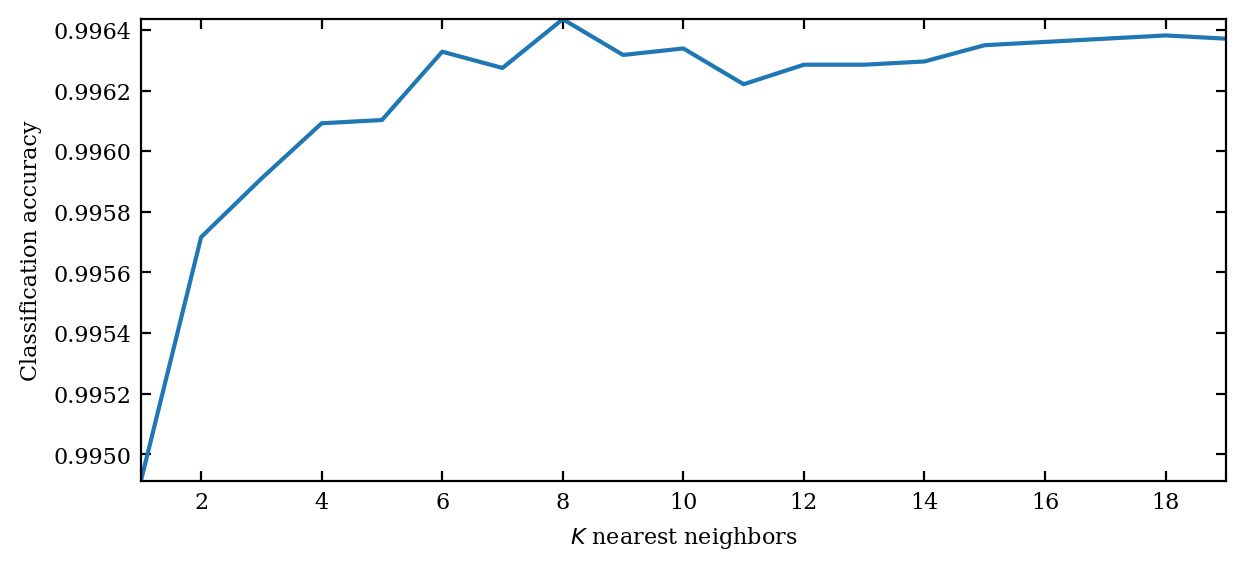

In [17]:
print("max score is for k={:d}".format(kvals[np.argmax(scores)]))

# Plot number of neighbors vs score
fig = plt.figure(figsize=(7, 3))
u = np.arange(len(scores))+1
plt.plot(u,scores)
plt.xlabel('$K$ nearest neighbors')
plt.ylabel('Classification accuracy')

Ah, that's where $K=8$ came from. 

We can also use the [`metrics` module](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) in sklearn to compute some statistics for us. Remember the definitions of **precision** and **recall** from above.

In [18]:
from sklearn import metrics 

#print(k, nc)
print("accuracy:", metrics.accuracy_score(y_test, y_pred))
print("precision:", metrics.precision_score(y_test, y_pred))
print("recall:", metrics.recall_score(y_test, y_pred))

accuracy: 0.9962638495233187
precision: 0.75
recall: 0.5474452554744526
